# Linear Regression
In this lab we will review one of the most basic regression algorithms for data exploration, its mathematical background is quite simple and we will further see its big limitations.

## Wine Dataset
Let us start describing the dataset we will be working on. The dataset can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). This dataset contains samples from the *vinho verde* wine producer both for white and red wine.The goal is to model wine quality based on physicochemical tests.

## Training Data Loading
In the previous notebook we extracted and curated the original provided data and exported a compressed file jld. Let us retrieve the used information

In [1]:
using JLD, DataFrames
d = load(pwd()*"/data/clean_data/dataset.jld");
x_train = Array(d["x_train"]);
y_train = d["y_train"];
x_test = Array(d["x_test"]);
y_test = Array(d["y_test"]);

Add a columns of ones to the x train and test matrix so it counts the bias term as well

In [2]:
m,n = size(x_train);
x_train = hcat(ones(m),x_train);
o,p = size(x_test);
x_test = hcat(ones(o),x_test);

## Linear Regression
We will find a linear regression approximaiton to our data, as seen in class, we can find a closed solution easily
$$
\hat{\beta} = (X^\top X)^{-1}X^\top y
$$

In [3]:
beta_hat = (x_train'*x_train)\(x_train'*y_train)

12-element Array{Float64,1}:
  5.76947  
 -0.1095   
 -1.597    
 -0.0547709
  0.0538583
 -1.08264  
  0.525548 
 -1.28062  
  0.171474 
 -0.861531 
  1.48619  
  1.85638  

In [4]:
y_linear_train_predicted = x_train * beta_hat;
error = sum((y_train-y_linear_train_predicted).^2)

540.7602176986741

In [5]:
y_linear_test_predicted = x_test * beta_hat;
error = sum((y_test-y_linear_test_predicted).^2)

129.29261196757125

In [6]:
rank(x_train)

12

In [7]:
using MultivariateStats
a = llsq(x_train, y_train; bias=false)

INFO: Precompiling module MultivariateStats.


12-element Array{Float64,1}:
  5.76947  
 -0.1095   
 -1.597    
 -0.0547709
  0.0538583
 -1.08264  
  0.525548 
 -1.28062  
  0.171474 
 -0.861531 
  1.48619  
  1.85638  

## Ridge Regression

In [8]:
lambda = 0.1;
beta_ridge = (x_train'*x_train + lambda * eye(n+1))\(x_train'*y_train)

12-element Array{Float64,1}:
  5.7221   
 -0.0531601
 -1.57937  
 -0.0474178
  0.0631675
 -1.04183  
  0.515584 
 -1.25182  
  0.143518 
 -0.792756 
  1.48103  
  1.84717  

In [9]:
y_ridge_train_predicted = x_train * beta_ridge;
error = sum((y_train-y_ridge_train_predicted).^2) + lambda * sum(beta_ridge.^2)

545.2489419597015

In [11]:
y_ridge_predicted = x_test * beta_ridge;
error = sum((y_test-y_ridge_predicted).^2)+ lambda * sum(beta_ridge.^2)

133.44751980260483

In [12]:
a = ridge(x_train, y_train, lambda; bias=false)

12-element Array{Float64,1}:
  5.7221   
 -0.0531601
 -1.57937  
 -0.0474178
  0.0631675
 -1.04183  
  0.515584 
 -1.25182  
  0.143518 
 -0.792756 
  1.48103  
  1.84717  

In [18]:
# prepare data
X = ones(1000, 3)
a0, b0 = rand(3), rand()
y = X * a0 + b0 + 0.1 * randn(1000)
println(rank(X))

# solve using llsq
l = 0.1
sol = ridge(X, y, l)

# extract results
a, b = sol[1:end-1], sol[end]

# do prediction
yp = X * a + b

1


1000-element Array{Float64,1}:
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 ⋮      
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459
 2.35459

## Lasso Regression

### Proximal Gradient Method
We will use a forward-backward approach according to the following update rule

$$
\beta_{i+1} = prox_{\tau\partial f}(\beta_i+2\tau X^\top(y-X\beta_i))
$$

In [14]:
function prox_l1(beta, lambda)
    return max.(0,beta-lambda) - max.(0,-beta-lambda)
end

prox_l1 (generic function with 2 methods)

In [15]:
function lasso_cost(y,X,beta,lambda)
    return 0.5*norm(y-X*beta)^2 + 0.5*lambda * norm(beta)^2
end

lasso_cost (generic function with 1 method)

In [66]:
beta = zeros(12)
tau = 0.0002
lambda = 0.01
gamma = 0.5
niter = 10000
tol = 1e-3
res = 1
iter = 0
costs = []
beta_prev = beta;

In [67]:
for i in 1:niter
    iter += 1
    grad_g = 2*(x_train'*x_train)*beta - x_train'*y_train
    z = prox_l1(beta - tau*grad_g,tau*lambda)
    cost = lasso_cost(y_train,x_train,z,lambda)
    #tau = gamma*tau
    beta_prev = beta
    beta = z
    
    append!(costs,cost)
    #println(cost)
end
println(beta)

[2.88364, -0.0503755, -0.798128, -0.0272976, 0.0281897, -0.539567, 0.261958, -0.63882, 0.0816801, -0.427082, 0.743112, 0.926391]


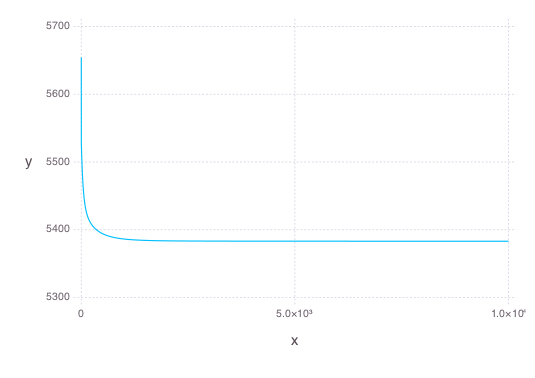

In [68]:
using Gadfly
plot(x=1:length(costs), y=costs, Geom.line)

In [69]:
y_lasso_train_predicted = x_train * beta;
error = sum((y_train-y_lasso_train_predicted).^2) + lambda * norm(beta,1)

10766.2223417134

In [70]:
y_lasso_test_predicted = x_test * beta;
error = sum((y_test-y_lasso_test_predicted).^2) + lambda * norm(beta,1)

2695.300224316927